## Testing evolve tent pitching with solution
$$ \sin\left(ct+\sum_{i=1}^{dim} \sqrt{\frac{1}{dim}}x_i\right)$$

In [1]:
import sys
sys.path.append("..")
from ngsolve import *
SetHeapSize(100*1000*1000)

from ngsolve import *
from ngsolve.comp import *
from ngsolve.TensorProductTools import *
import netgen.meshing as ngm
from netgen.geom2d import unit_square
from netgen.csg import unit_cube
from trefftzngs import *
from DGeq import *
from prodmesh import * 
# import netgen.gui
import scipy as sp
import scipy.sparse.linalg
import scipy.linalg
import time
from scipy.io import savemat
from scipy.io import loadmat
from netgen.csg import unit_cube

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
t_start = 0
t_end = 5

def hpplot(error,xrange,maxh):
    fig = plt.figure()
    ax = fig.gca()
    for i,h in enumerate(maxh):
        plt.semilogy(xrange , error[i], '-o', label="h="+str(h))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #plt.title('Wavespeed: ' + str(c) + " dim: " + str(initmesh.dim) + "+1")
    plt.legend()
    plt.ylabel("L2-error")
    plt.xlabel("order")
    #plt.savefig("results/pvtv3_"+label[yaxis]+label[xaxis]+".png")
    plt.show()
    
def hploop(meshes,maxh,maxorder,c):
    error = [None] * len(meshes)
    for i,initmesh in enumerate(meshes):
        error[i] = []
        for order in range(2,maxorder):
            wavefront = EvolveTentsMakeWavefront(order,initmesh,c,t_start)
            mat = EvolveTents(order,initmesh,c,t_end,wavefront,0)
            l2err = EvolveTentsL2Error(order,initmesh,mat,EvolveTentsMakeWavefront(order,initmesh,c,t_end))
            error[i].append(l2err)
    hpplot(error,range(2,maxorder),maxh)

## timing

In [3]:
t_start=0
order=3
c=3
t_end=1
initmesh = Mesh(unit_cube.GenerateMesh(maxh=0.4))
wavefront = EvolveTentsMakeWavefront(order,initmesh,c,t_start)
mat = EvolveTents(order,initmesh,c,t_end,wavefront,0)
l2err = EvolveTentsL2Error(order,initmesh,mat,EvolveTentsMakeWavefront(order,initmesh,c,t_end))

for t in Timers():
    print(t)

{'name': 'tent eval', 'time': 1.5928568840026855, 'counts': 841, 'flops': 0, 'Gflop/s': 0.0}
{'name': 'tentsolve', 'time': 0.023862600326538086, 'counts': 841, 'flops': 0, 'Gflop/s': 0.0}
{'name': 'tent', 'time': 6.29410719871521, 'counts': 841, 'flops': 0, 'Gflop/s': 0.0}
{'name': 'pitch tents', 'time': 0.0034160614013671875, 'counts': 1, 'flops': 0, 'Gflop/s': 0.0}
{'name': 'CalcIdentifiedFacets', 'time': 9.5367431640625e-07, 'counts': 1, 'flops': 0, 'Gflop/s': 0.0}
{'name': 'MeshAccess::UpdateBuffers', 'time': 2.2172927856445312e-05, 'counts': 1, 'flops': 0, 'Gflop/s': 0.0}
{'name': 'H1FESpace::GetFE', 'time': 0.0, 'counts': 0, 'flops': 0, 'Gflop/s': nan}
{'name': 'SparseMatrixSymmetric::AddElementMatrix', 'time': 0.0, 'counts': 0, 'flops': 0, 'Gflop/s': nan}
{'name': 'SparseMatrix::AddElementMatrix', 'time': 0.0, 'counts': 0, 'flops': 0, 'Gflop/s': nan}
{'name': 'AddABt-double-complex, sym', 'time': 0.0, 'counts': 0, 'flops': 0, 'Gflop/s': nan}
{'name': 'AddABt-double-complex', 'ti

In [4]:
12/841 #30 dofs

0.014268727705112961

## p-convergence 

In [5]:
maxorder=5
c = 3
t_start = 0
t_end = 2
meshes = [Mesh(QadSegMesh(4,0,1)),\
          Mesh(unit_square.GenerateMesh(maxh=0.5)),\
          Mesh(unit_cube.GenerateMesh(maxh = 0.5))]

for initmesh in meshes:
    print("dim: " + str(initmesh.dim))
    for order in range(2,maxorder):
        wavefront = EvolveTentsMakeWavefront(order,initmesh,c,t_start)
        mat = EvolveTents(order,initmesh,c,t_end,wavefront,0)
        l2err = EvolveTentsL2Error(order,initmesh,mat,EvolveTentsMakeWavefront(order,initmesh,c,t_end))
        print("order: " + str(order) + " err: " + str(l2err))

dim: 1
order: 2 err: 0.02807308796974218
order: 3 err: 0.08199055497935258
order: 4 err: 0.0077599780225787555
dim: 2
order: 2 err: 0.01158058255154382
order: 3 err: 0.00032849491141283033
order: 4 err: 6.94278222837652e-05
dim: 3
order: 2 err: 0.014362494727802143
order: 3 err: 0.00043105310198281594
order: 4 err: 8.90997912564842e-05


## hp-convergence

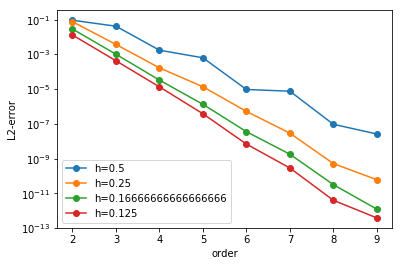

In [6]:
c = 10
maxorder = 10
meshes = [Mesh(SegMesh(h,0,1)) for h in range(2,9,2)]
maxh = [1/h for h in range(2,9,2)]
hploop(meshes,maxh,maxorder,c)

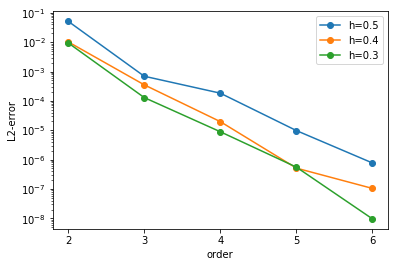

In [7]:
maxorder = 7
c = 5
meshes = [Mesh(unit_square.GenerateMesh(maxh=h)) for h in [0.5,0.4,0.3]]
maxh = [h for h in [0.5,0.4,0.3]]
hploop(meshes,maxh,maxorder,c)

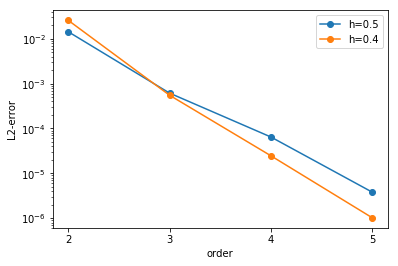

In [8]:
maxorder = 6
c = 3
t_end = 1
meshes = [Mesh(unit_cube.GenerateMesh(maxh=h)) for h in [0.5,0.4]]
maxh = [h for h in [0.5,0.4]]
hploop(meshes,maxh,maxorder,c)

## Energy

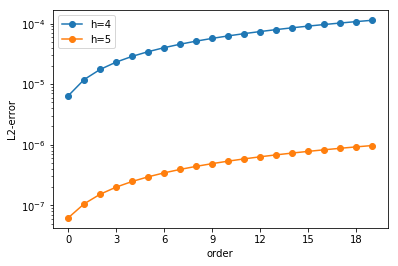

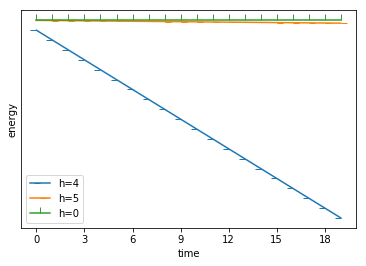

In [9]:
maxorder = 6
minorder=4
t_start = 0
t_step = 50
t_end = 1000
c = 1
initmesh = Mesh(SegMesh(10,0,1)) #Mesh(unit_square.GenerateMesh(maxh=0.09))
#for i in range(0,len(initmesh.GetBoundaries())):
#    initmesh.ngmesh.SetBCName(i,"neumann")

error = [None] * maxorder
energy = [None] * maxorder

for o,order in enumerate(range(minorder,maxorder)):
    t_start = 0
    wavefront = EvolveTentsMakeWavefront(order,initmesh,c,t_start)
    error[o] = []
    energy[o] = []
    while t_start < t_end:
        wavefront = EvolveTents(order,initmesh,c,t_step,wavefront,t_start)
        t_start += t_step
        l2err = EvolveTentsL2Error(order,initmesh,wavefront,EvolveTentsMakeWavefront(order,initmesh,c,t_start))
        egy = EvolveTentsEnergy(order,initmesh,wavefront,c)
        error[o].append(l2err)
        energy[o].append(egy)
        
t_start = 0
error[o+1] = []
energy[o+1] = []
while t_start < t_end:
    t_start += t_step
    energy[o+1].append(EvolveTentsEnergy(order,initmesh,EvolveTentsMakeWavefront(order,initmesh,c,t_start),c))
foo=list(range(minorder,maxorder))
foo.append(0)
hpplot(error,range(0,int(t_end/t_step)),range(minorder,maxorder))
#hpplot(energy,range(0,int(t_end/t_step)),foo)

xrange=range(int(t_end/t_step))
maxh=list(range(minorder,maxorder))
maxh.append(0)
fig = plt.figure()
ax = fig.gca()
for i,h in enumerate(maxh):
    plt.semilogy(xrange , energy[i], marker=i, label="h="+str(h))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#plt.title('Wavespeed: ' + str(c) + " dim: " + str(initmesh.dim) + "+1")
plt.legend()
plt.ylabel("energy")
plt.xlabel("time")
#plt.savefig("results/pvtv3_"+label[yaxis]+label[xaxis]+".png")
plt.show()